<a href="https://colab.research.google.com/github/t-willi/Noise2Puls/blob/main/Testing_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load data and set up environment

In [2]:
!pip install wandb
!pip install ecg_plot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


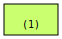

In [3]:
from torchviz import make_dot
import torch
x=torch.Tensor([5])
m=torch.Tensor([2])
b=torch.Tensor([3])
y=m*x+b
make_dot(y)

In [4]:
import pathlib
from pathlib import Path
# current_position=pathlib.PurePath(__file__)
# dir=current_position.parent
# main_folder=dir.joinpath("main_folder")
current_position=pathlib.PurePath("/content/")
main_folder=current_position.joinpath("main_folder")
Path(main_folder).mkdir(parents=False,exist_ok = True)
#create folder and directory for artifacts
artifact_dir=main_folder.joinpath("artifacts")
Path(artifact_dir).mkdir(parents=False,exist_ok = True)
#create folder and directory for train_data
train_dir=main_folder.joinpath("train_dir")
Path(train_dir).mkdir(parents=False,exist_ok = True)
#create folder and directory for ecg_files
ecg_dir=main_folder.joinpath("ecg")
Path(ecg_dir).mkdir(parents=False,exist_ok = True)
#create folder and directory for saved model sate dicts
model_dir=main_folder.joinpath("model")
Path(model_dir).mkdir(parents=False,exist_ok = True)

In [5]:
import wandb
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import torch.optim as optim
from random import shuffle
from tqdm.auto import tqdm
import requests
import zipfile
from pathlib import Path

if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

def request(path=None,name=None):
  import requests
  from pathlib import Path
  request = requests.get(path)
  name=name+".py"
  with open(name,"wb") as f:
    f.write(request.content)

unzip_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/unzip.py"
request(unzip_git_dir,"Unzip")
from Unzip import unzip

wandb.login(key="7a8ee9d41cc2d51eb77fd795e14f74a215e63c2d")
api = wandb.Api()
artifact = api.artifact('ecg_simula/setup_weights and biases/ecg_25000.zip:v0')
artifact.download(artifact_dir)
unzip(save_path="custom_data/train",zip_path="/content/main_folder/artifacts/ecg_25000.zip",reload=False)
torch.manual_seed(42)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: twilli (ecg_simula). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact ecg_25000.zip:v0, 1383.92MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


custom_data/train directory exists.


#Import custom dataset and create dataset and loader



In [6]:
import glob
import pandas as pd
import torch
class Custom_dataset_syn():
    def __init__(self, data_dir,max_value=5011,column=3,split=True,target="train",size=1):
      #get all files from directory loaded in all_files list
      self.column=column
      self.max_value=max_value
      self.size=size
      #should shuffle the data here?
      self.files = glob.glob(data_dir + '/*.asc')
      self.len=int((len(self.files))*self.size)
      #print(f"len:{self.len}")
      self.cut1=int(self.len*0.8)
      #print(f"cut1:{self.cut1}")
      self.cut2=int(self.len*0.9)
      #print(f"cut2:{self.cut2}")
      self.train_files=self.files[0:self.cut1]
      self.test_files=self.files[self.cut1:self.cut2]
      self.val_files=self.files[self.cut2:self.len]
      self.target=target
      self.split=split

    def __len__(self):
      if self.split is True:
        if self.target is "train":
          return len(self.train_files)
        if self.target is "test":
          return len(self.test_files)
        if self.target is "val":
          return len(self.val_files)
      if self.split is not True:
        return len(self.files)

    def __getitem__(self,idx):
      header = ["I","II","v1","v2","v3","v4","v5","v6"]
      #turn list of dataframes into Tensor
      if self.split is True:
        if self.target is "train":
          temp_df=pd.read_csv(self.train_files[idx],sep=" ", names = header)
        if self.target is "test":
          temp_df=pd.read_csv(self.test_files[idx],sep=" ", names = header)
        if self.target is "val":
          temp_df=pd.read_csv(self.val_files[idx],sep=" ", names = header)
      if self.split is not True:
        temp_df=pd.read_csv(self.files[idx],sep=" ", names = header)
      temp_df/=self.max_value
      #load input tensor
      
      temp_list_in=temp_df.loc[:,"I"]
      #temp_list_in=normalize([temp_list_in], norm="max")
      temp_tensor_in = torch.tensor(temp_list_in,dtype=torch.float32)
      temp_tensor_in=temp_tensor_in.unsqueeze(0)
      #load label Tensor
      temp_list_out=temp_df.loc[:,["II","v1","v2","v3","v4","v5","v6"]].values
      #temp_list_out=normalize([temp_list_out], norm="max")
      temp_tensor_out=torch.tensor(temp_list_out,dtype=torch.float32).T
      #combine input and label and output
      temp_tensor_pair= temp_tensor_in,temp_tensor_out
      return temp_tensor_pair


def make_loader(dataset,batch_size):
  from torch.utils.data import DataLoader
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last=True
                      )
  return loader


def plotECG_12Lead(df1=None,df2=None,title=None,pad_df2=True,path=None,createECG=True,scale=None):
  """
  takes two dataframes with identical columns, concats them and plots them as ecg using ecg_plot
  it also takes the first column of df1 and ads it to df1 if pad_df2 is True
  """
  import ecg_plot
  index=["real_I","real_II","real_III","real_aVR","real_aVL","real_aVF","real_v1","real_v2","real_v3","real_v4","real_v5","real_v6","real_I",
         "pred_II","pred_III","pred_aVR","pred_aVL","pred_aVF","pred_v1","pred_v2","pred_v3","pred_v4","pred_v5","pred_v6"]
  if createECG==True:
    ecg_path=path
    if Path(ecg_path).is_dir():
        print(f"{ecg_path} directory exists.")
    else:
        print(f"Did not find {ecg_path} directory, creating one...")
        Path(ecg_path).mkdir(parents=True, exist_ok=False)
  if scale:
    frames=[df1/1000,df2/1000]
  if scale is None:
    frames=[df1,df2]
  combined_df=pd.concat(frames,axis=1,join="outer",)
  if createECG is True:
    ecg_plot.plot(combined_df.values.T, sample_rate = 500,lead_index = index )
    ecg_plot.save_as_png(f'ecg{title}',ecg_path+"/")
  return combined_df

  
def get_pred_12lead(dataset=None,Set=None,model=None,random=True,upscale=None):
  """
  Function takes a Tensor Dataset as input,first a random file from the dataset is selected,
  then the Tensor pair is recombined and shaped into a df-->df_Input. 
  X is used afterwards as input into the model. The predictions are safed as --> df_output.
  Both dataframes are now unscaled by 5011, the max value of the whole dataset.
  Then a tuple pair of input and output is returned.
  """
  if random:
    import random
    limit=len(dataset)
    rand_idx=random.randint(0,limit)
    X,y=dataset[rand_idx]
  if random is False:
      X,y=Set
  #need to combine tensors to make dataframe for plotting input and output side by side
  full_tensor=torch.cat((X,y.squeeze()))
  full_tensor=full_tensor.numpy()
  df_input=pd.DataFrame(full_tensor).T
  df_input.columns = ["real_I","real_II","real_v1","real_v2","real_v3","real_v4","real_v5","real_v6"]
  model.to("cpu")
  model.eval()
  with torch.inference_mode():
    output=model(X)
  output=output.detach().numpy()
  output=output.squeeze().T
  #unscale data
  df_output = pd.DataFrame(output,columns=["pred_II","pred_v1","pred_v2","pred_v3","pred_v4","pred_v5","pred_v6"])
  #calculate the 4 missing leads
  df_input.insert(2, "real_III", df_input["real_II"] - df_input["real_I"])
  df_input.insert(3,"real_aVR",0.5*(df_input["real_I"] + df_input["real_II"]))
  df_input.insert(4,"real_aVL",(df_input["real_I"] -0.5) * df_input["real_II"])
  df_input.insert(5,"real_aVF",(df_input["real_II"] -0.5) * df_input["real_I"])
  df_output.insert(0,"real_I",df_input["real_I"])
  df_output.insert(2,"real_III",df_output["pred_II"] - df_output["real_I"])
  df_output.insert(3,"real_aVR",0.5*(df_output["real_I"] + df_output["pred_II"]))
  df_output.insert(4,"real_aVL",(df_output["real_I"] -0.5) * df_output["pred_II"])
  df_output.insert(5,"real_aVF",(df_output["pred_II"] -0.5) * df_output["real_I"])
  if upscale:
    df_input=df_input*upscale
    df_output=df_output*upscale
    
  return df_input,df_output

# lead III value = (lead II value) - (lead I value)
# lead aVR value = -0.5*(lead I value + lead II value)
# lead aVL value = lead I value - 0.5 * lead II value
# lead aVF value = lead II value - 0.5 * lead I value


#set data

In [7]:
data_dir="/content/custom_data/train"
train_data=Custom_dataset_syn(data_dir=data_dir,target="train",size=0.05)
val_data=Custom_dataset_syn(data_dir=data_dir,target="val",size=0.05)
train_loader=make_loader(train_data,32)
val_loader=make_loader(val_data,32)


#Set up function for getting noise and sampling data

In [8]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
device="cpu"
class Diffusion:
    def __init__(self, noise_steps=100, beta_start=1e-4, beta_end=0.001, device=device):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.device = device

    def prepare_noise_schedule(self):
        """
        returns betas from beta start to beta end with amount of steps equal to noise_steps
        """
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)  
        

    def noise_images(self, leads, t):
        """
        takes data(x) and timestep(t), gets alphas from alpha lists using t as index, where t is a tensor of shape(batchsize)
        That returns a tensor of alphas in shape batchsize, then gets dimensions added. tensor(batchsize) --> tensor(batchsize,1,1,1)
        this is done so that alphas can be multiplies with x and Ɛ. Example for the result: alphas times x results in all
        pricture values beeing multiplied with one alpha value. The batchsize is not multiplied or effected in any way. the shape of
        the picture stays the same. same goes for multipling alphas with noise.
        function also returns noise, since we are using it in the loss function.

        """
        #print(f"shape of t is {t.shape}")
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]   # alpha tensors need to have same ndim as x, where x will be (batch,7,5000)
        #print(f"shape of sqrt_alpha_hat is {sqrt_alpha_hat.shape}")
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None]
        #print(f"shape of sqrt_one_minus_alpha_hat is {sqrt_one_minus_alpha_hat.shape}")
        Ɛ = torch.randn_like(leads)
        #print(f"shape of noise is {Ɛ.shape}")
        leads_t,noise=sqrt_alpha_hat * leads + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
        leads_t=leads_t.squeeze()
        #print(f"shape of leads_t is {leads_t.shape}")
        return leads_t,noise

    def sample_timesteps(self, n):
        """
        returns a tensor with lenght of n, that is uaualy equal to batch size.
        Its batch size so it can be applied to the alphas tensors, to return alpha tensors that can be applied to all data in one batch
        """
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, condition):
        """
        function takes model, x(y leads),batch size and y(lead1)
        """
        model.eval()
        with torch.inference_mode():
            x = torch.randn((7,5000)).to(self.device) # random tensor of shape (n,7,5000) taken from normal distribution
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0): #steps down from i=1000 to i=1
                t = (torch.ones(1) * i).long().to(self.device) # makes a tensor of lenght n filled with 1s, then multiplies by timestep
                predicted_noise = model(x, t, condition) #takes x and t and labels as conditions.
                alpha = self.alpha[t][:, None, None] # indexes alpha values with tensor t, returns alphas in shape (n,1,1)
                alpha_hat = self.alpha_hat[t][:, None, None] #same here
                beta = self.beta[t][:, None, None] #same here
                if i > 1:
                    noise = torch.randn_like(x) # if i is larger then 1, we have not reached the noise free data, so noise is sampled 
                else:
                    noise = torch.zeros_like(x) # if i is not larger then 1, we have reached the final step, no more noise should be added
                # takes in x, noise and predicted noise and generates 7 leads from noise
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise 
        model.train()
        x=x.squeeze()
        #x = (x.clamp(-1, 1) + 1) / 2  #this just scales the data to  between (0,1)
        #x = (x * 255).type(torch.uint8) #then multiplies values by 255 for picture, we will scale the data as neccesary to be in mV and between -5 and 5
        return x




In [9]:
diffusion = Diffusion(device=device)
#t=diffusion.sample_timesteps(n=1)
t=torch.tensor([99],dtype=torch.int64)
x,leads=train_data[0]
leads_t,noise=diffusion.noise_images(leads,t)

In [10]:
leads.shape,leads_t.shape
df_in,df_out=pd.DataFrame(leads.numpy().T),pd.DataFrame(leads_t.numpy().T)
df_in=df_in*5
df_out=df_out*5
print(t)

tensor([99])


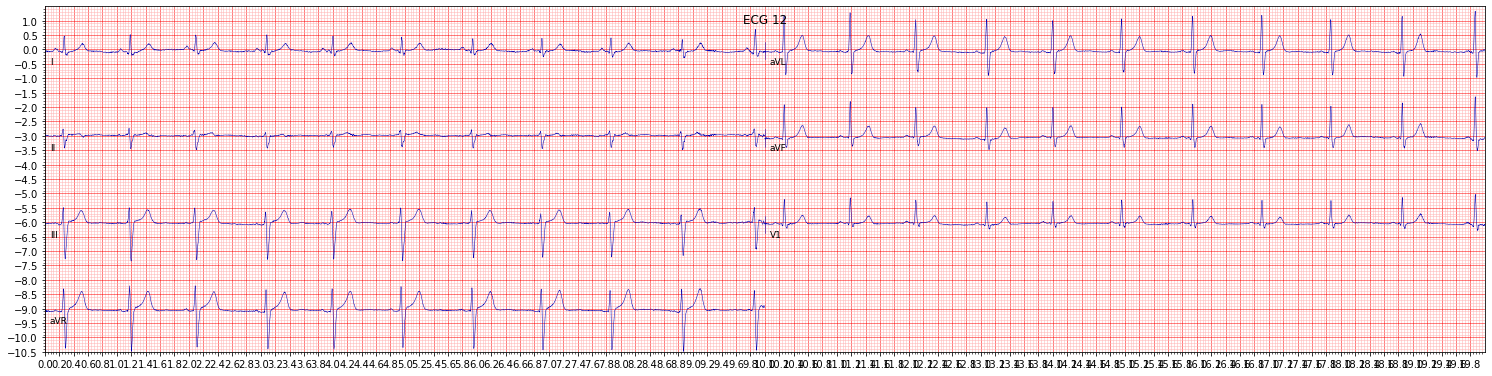

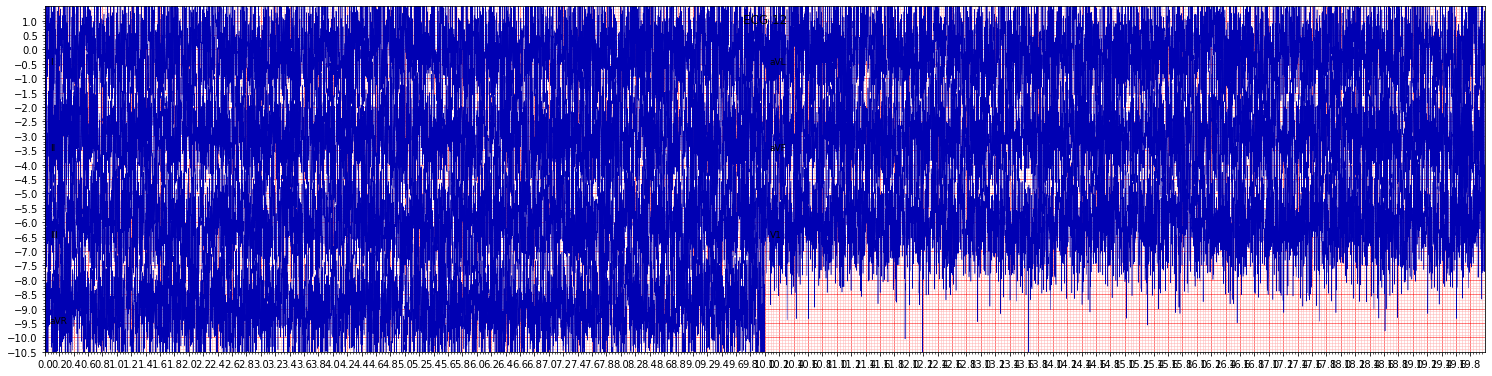

In [11]:
import ecg_plot
ecg_plot.plot(df_in.values.T)
ecg_plot.plot(df_out.values.T)


#Import model


In [69]:
 # Modified version:Vajira Thambawita

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data


class up_first_last(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=11, upsample=None, output_padding=1):
        super(up_first_last, self).__init__()
        self.upsample = upsample
        self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        reflection_pad = kernel_size // 2
        self.reflection_pad = nn.ConstantPad1d(reflection_pad, value=0)
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        self.Conv1dTrans = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

    def forward(self, leads):
        if self.upsample:
          #print(f"x_input_{x.shape}")
          leads = self.conv1d(self.reflection_pad(self.upsample_layer(leads)))
          #print(f"x_output_{x.shape}")
          return leads
        else:
          return self.Conv1dTrans(leads)

class up(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=11, upsample=None, output_padding=1,emb_dim=256):
        super(up, self).__init__()
        self.upsample = upsample

        self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        reflection_pad = kernel_size // 2
        self.reflection_pad = nn.ConstantPad1d(reflection_pad, value=0)
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        self.Conv1dTrans = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

#         # this is for t to be transformed 
#         self.emb_layer = nn.Sequential(
#             nn.SiLU(),
#             nn.Linear(
#                 emb_dim,  ## this should be the inital size of t
#                 out_channels
# #            ),
# #        )

    def forward(self, leads, leads_skip,t,condition):
        #print("we are in up")
        if self.upsample:
            leads = torch.cat((leads, leads_skip), 1)
            leads=self.conv1d(self.reflection_pad(self.upsample_layer(leads)))
            emb = (t)[:, :, None].repeat(1, leads.shape[-2], leads.shape[-1])
            if condition is not None:
              #print(f"shape of condition before layer_{condition.shape}")
              reshape_layer=nn.Linear(condition.shape[2],emb.shape[2])
              condition_shaped=reshape_layer(condition)
              condition_shaped=condition_shaped.repeat(1,emb.shape[1],1)
              #print(f"shape of emb _{emb.shape}")
              #print(f"shape of condition after layer_{condition_shaped.shape}")
              emb+=condition_shaped
              #print(f"shape of leads{leads.shape}")
            return leads+emb
        else:
            return self.Conv1dTrans(leads)

            

class down(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,emb_dim=28):
        super(down, self).__init__()
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride,padding)
        # # this is for t to be transformed 
        # self.emb_layer = nn.Sequential(
        #     nn.SiLU(),
        #     nn.Linear(
        #         emb_dim,  ## this should be the inital size of t
        #         out_channels
        #     ),
        # )

    def forward(self, leads,t,condition):
      #print("we are in down")
      #print(f"shape of leads before_{leads.shape}")
      leads=self.conv1d(leads) 
      #print(f"shape of leads after layer_{leads.shape}")
      #print(f"shape of t before embedding_{t.shape}")
      t=t[:,:,None]
      emb = t.repeat(1, leads.shape[-2], leads.shape[-1])
      #print(f"shape of emb after embedding_{emb.shape}")
      if condition is not None: #(batch,1,5000)
        #condition=condition.squeeze(1) 
        #print(f"shape of condition before layer_{condition.shape}")
        reshape_layer=nn.Linear(condition.shape[2],emb.shape[2])
        condition_shaped=reshape_layer(condition)
        condition_shaped=condition_shaped.repeat(1,emb.shape[1],1)
        #print(f"shape of condition after layer_{condition_shaped.shape}")
        emb+=condition_shaped
        #print(f"shape of output down_{emb.shape}")
        leads+=emb
      return leads



class noise2pulse(nn.Module):
    def __init__(self, model_size=50, ngpus=1, num_channels=7,
                 latent_dim=100, post_proc_filt_len=512,
                 verbose=False, upsample=True, num_classes=None,time_dim=1,device=device):
        super(noise2pulse, self).__init__()
        self.ngpus = ngpus
        self.model_size = model_size  # d
        self.num_channels = num_channels  # c
        self.time_dim=time_dim
        self.device=device
        #self.latent_di = latent_dim
        #self.post_proc_filt_len = post_proc_filt_len
  

       #Down layers
        self.conv_1 = down(num_channels, 10, 25, stride=2, padding=25 // 2)
        self.conv_2 = down(10, 25, 25, stride=5, padding= 25 // 2)
        self.conv_3 = down(25, 50 , 25, stride=2, padding= 25 // 2)
        self.conv_4 = down(50, 150 , 25, stride=5, padding= 25 // 2)
        self.conv_5 = down(150, 250 , 25, stride=5, padding= 25 // 2)
        self.conv_6 = down(250, 250 , 25, stride=5, padding= 25 // 2)

        # Up layers
        stride = 4
        if upsample:
            stride = 1
            upsample = 5
        self.deconv_1 = up_first_last(250 , 250, 25, stride, upsample=upsample)
        self.deconv_2 = up(500, 150, 25, stride, upsample=upsample)
        self.deconv_3 = up(300,  50, 25, stride, upsample=upsample)
        self.deconv_4 = up(100, 25, 25, stride, upsample=2)
        self.deconv_5 = up( 50, 10, 25, stride, upsample=upsample)
        self.deconv_6 = up_first_last(10, 7, 25, stride, upsample=2)


      #   self.deconv_1 = Transpose1dLayer(5 * model_size , 5 * model_size, 25, stride, upsample=upsample)
      #   self.deconv_2 = Transpose1dLayer_multi_input(5 * model_size * 2, 3 * model_size, 25, stride, upsample=upsample)
      #   self.deconv_3 = Transpose1dLayer_multi_input(3 * model_size * 2,  model_size, 25, stride, upsample=upsample)
      #  # self.deconv_4 = Transpose1dLayer( model_size, model_size, 25, stride, upsample=upsample)
      #   self.deconv_5 = Transpose1dLayer_multi_input( model_size * 2, int(model_size / 2), 25, stride, upsample=2)
      #   self.deconv_6 = Transpose1dLayer_multi_input(  int(model_size / 2) * 2, int(model_size / 5), 25, stride, upsample=upsample)
      #   self.deconv_7 = Transpose1dLayer(  int(model_size / 5), num_channels, 25, stride, upsample=2)

#        if post_proc_filt_len:
#            self.ppfilter1 = nn.Conv1d(num_channels, num_channels, post_proc_filt_len)

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight.data)

        #self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        """
        takes in t and channels, returns pos_enc with shape (batch,channels)
        """
        # inv_freq = 1.0 / (
        #     10000
        #     ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        # )
        # pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        # pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        # pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        pos_enc = torch.sin(t)
        return pos_enc

    def forward(self,leads,t,condition):

        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)


        #if y is not None:
            #t += self.label_emb(y)
        #print("one")
        conv_1_out = F.leaky_relu(self.conv_1(leads,t,condition)) # x=1,7,5000 -- 1,10,2500
        #print("two",conv_1_out.shape)
        conv_2_out = F.leaky_relu(self.conv_2(conv_1_out,t,condition)) #1,25,500
        #print("three",conv_2_out.shape)
        conv_3_out = F.leaky_relu(self.conv_3(conv_2_out,t,condition)) #1,50,250
        #print("four",conv_3_out.shape)
        conv_4_out = F.leaky_relu(self.conv_4(conv_3_out,t,condition)) # 1,150,50
        #print("5",conv_4_out.shape)
        conv_5_out = F.leaky_relu(self.conv_5(conv_4_out,t,condition)) #1,250,10
        #print("6",conv_5_out.shape)
        conv_6_out = F.leaky_relu(self.conv_6(conv_5_out,t,condition)) #1,250,2
        #print("7",conv_6_out.shape)

        deconv_1_out = F.relu(self.deconv_1(conv_6_out)) #1,250,10
        #print("8",deconv_1_out.shape)
        deconv_2_out = F.relu(self.deconv_2(deconv_1_out, conv_5_out,t,condition))
        #print("9",deconv_2_out.shape)
        deconv_3_out = F.relu(self.deconv_3(deconv_2_out, conv_4_out,t,condition))
        #print("10",deconv_3_out.shape)
        deconv_4_out = F.relu(self.deconv_4(deconv_3_out, conv_3_out,t,condition))
        #print("11",deconv_4_out.shape)
        deconv_5_out = F.relu(self.deconv_5(deconv_4_out, conv_2_out,t,condition))
        #print("12",deconv_5_out.shape)
        output =   torch.tanh(self.deconv_6(deconv_5_out))
        #print("13",output.shape)


        return output

model=noise2pulse()








/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [48]:
out_channel=50
t=torch.rand(32)
t = t.unsqueeze(-1).type(torch.float)
channels=5000
condition=torch.rand(32,1,5000)
def pos_encoding(t=t, channels=channels):
      inv_freq = 1.0 / (
          10000
          ** (torch.arange(0, channels, 2).float() / channels)
      )
      pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
      pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
      pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
      pos_enc=pos_enc[:,None,:]
      return pos_enc
output=pos_encoding()
output.shape
# result=output+condition
# result.shape

torch.Size([32, 1, 5000])

In [13]:
condition=torch.rand(32,1,5000)
emb=torch.rand(32,7,5000)
condition=condition.repeat(1,emb.shape[1],1)
condition.shape



torch.Size([32, 7, 5000])

In [14]:
t=torch.rand(32,1)
t=t[:,:,None]
leads=torch.rand(1,7,5000)
t=t.repeat(1,leads.shape[-2],leads.shape[-1])
t.shape

torch.Size([32, 7, 5000])

#Init wandB

In [16]:
def setup_wandb():
  config = dict(
      epochs=20,
      batch_size=32,
      learning_rate=0.0001,)
  wandb.init(project="N2P_colab_test")
  config = wandb.config
  


#Train model


In [71]:
from tqdm.auto import tqdm
import torchviz
from torchviz import make_dot
def train(device,train_loader,val_data,model):
    #setup_wandb()
    #wandb.watch(model,log="all")
    device = device
    train_loader = train_loader
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters())
    mse = nn.MSELoss()
    diffusion = Diffusion(device=device)
    l = len(train_loader)
    for epoch in tqdm(range(30)):
      train_loss=0
      for batch , (condition,leads) in tqdm(enumerate(train_loader)):
        condition,leads = condition.to(device),leads.to(device)
        t = diffusion.sample_timesteps(leads.shape[0]).to(device)
        leads_t, noise = diffusion.noise_images(leads, t)
        model.train()
        predicted_noise = model(leads_t, t, condition)
        loss = mse(noise, predicted_noise)
        train_loss+=loss
        #print(train_loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      # train_loss=loss/l
      # wandb.log({"train_loss": train_loss, 
      #                 "Epoch":epoch})
 
train(device=device,train_loader=train_loader,val_data=val_data,model=model)





  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: ignored

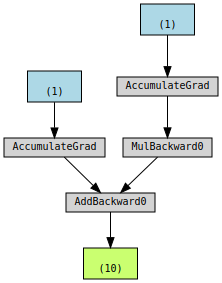

In [17]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
x_train_tensor=torch.Tensor([1,2,3,4,5,6,7,8,9,10])
y_train_tensor=torch.Tensor([1,2,3,4,5,6,7,8,9,10])
yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()
make_dot(yhat)

In [18]:
diffusion = Diffusion(device=device)
label,leads=train_data[0]
df_out=diffusion.sample(model=model, y=label)


TypeError: ignored

In [ ]:
df_out

In [ ]:
label,leads=train_data[0]
df_in=pd.DataFrame(leads.numpy().T)
df_noise=pd.DataFrame(df_out.squeeze(0).numpy().T)

In [ ]:
import ecg_plot
#df_in=df_in*5
df_noise=df_noise/5
#ecg_plot.plot(df_in.values.T)
ecg_plot.plot(df_noise.values.T)


In [ ]:
_=plotECG_12Lead(df1=df_in,df2=df_out,title="diffusion_ecg",path="/content/ecg",scale=True)